In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [63]:
from autoplan.token import OCamlTokenizer
from autoplan.trainer import ClassifierTrainer
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.dataset import TrainVal, build_synthetic_dataset, set_random_seed
from autoplan.generator import ProgramGenerator

from grammars.rainfall.ocaml import Program, Labels

from tqdm.auto import tqdm
from scripts.rainfall_ingest import ingest_dataset
import torch
import seaborn as sns
from iterextras import par_for
from pickle_cache import PickleCache
from torch import nn
import numpy as np
import dataclasses

pcache = PickleCache()
device = torch.device('cuda:7')

In [33]:
student_dataset = ingest_dataset('T1')

In [97]:
student_dataset.dataset[0]

{'source': 'fun rainfall(nums :: List<Number>) -> Number:\n  #this took approximatly 25-30 minutes\n  fun get-values(lst :: List<Number>) -> {sum : Number, length : Number}:\n    doc: "returns the sum of the correct values in lst, and the number of correct values"\n    cases(List<Numbers>) lst:\n      | empty => {sum : 0, length : 0}\n      | link(f,r) =>\n        if f == -999:\n          {sum : 0, length : 0}\n        else if f < 0:\n          v = get-values(r)\n          {sum : v.sum, length : v.length}\n        else:\n          v = get-values(r)\n          {sum : v.sum + f, length : v.length + 1}\n        end\n    end\n  end\n  vals = get-values(nums)\n  if vals.length == 0:\n    raise("error: no correct input values")\n  else:\n    vals.sum / vals.length\n  end\n  where:\n  test1 = [2, 10, 0, -5, 4, -999, 3, 5, -3]\n  test2 = []\n  test3 = [-999, 4, 8, 0]\n  test4 = [-5, 4, 8, 0]\n  test5 = [-4, -7, -2, -10, -999, 5, 7, -999]\n  rainfall(test1) is 4\n  rainfall(test2) raises("error

In [5]:
df = pd.DataFrame(list(student_dataset.dataset))

In [36]:
generator = ProgramGenerator(grammar=Program())
program, choices, choice_options, labels = generator.generate()
print(program)


fun rainfall(nums :: List<Number>) -> Number:
  

  fun helper(nums :: List<Number>, sum :: Number, count :: Number) -> Number:
    cases(List<Number>) nums:
      | empty =>
         if count == 0:
           0
         else:
           sum / count
         end
      | link(f, r) =>
        if f == -999:
          
          helper([], sum, count)
          
        else if f < 0:
          helper(r, sum, count)
        else:
          helper(r, sum + f, count + 1)
        end
    end
  end

        
  
  vals = helper(nums)
  if vals.length == 0:
    raise("error")
  else:
    vals.sum / vals.length
        
end
        


In [ ]:
synth_dataset = build_synthetic_dataset(
    GeneralRainfallLabels,
    N=1000,
    tokenizer=PyretTokenizer(),
    generator=ProgramGenerator(grammar=Program()),
    vocab_index=student_dataset.vocab_index)

In [83]:
trainer = ClassifierTrainer(synth_dataset, device)
losses = []
train_eval = []
val_eval = []

In [84]:
for _ in tqdm(range(50)):
    losses.append(trainer.train_one_epoch())
    train, val = trainer.eval()
    train_eval.append(train)
    val_eval.append(val)

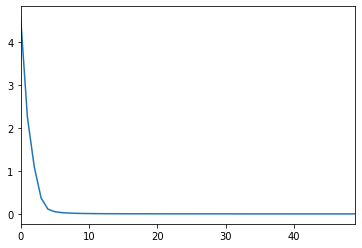

In [85]:
pd.Series(losses).plot()

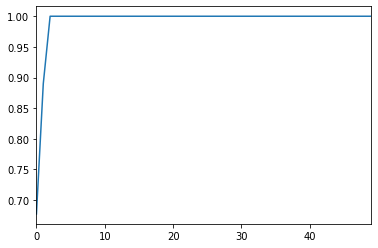

In [86]:
plot_accuracy(train_eval)

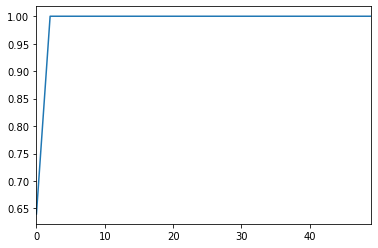

In [87]:
plot_accuracy(val_eval)

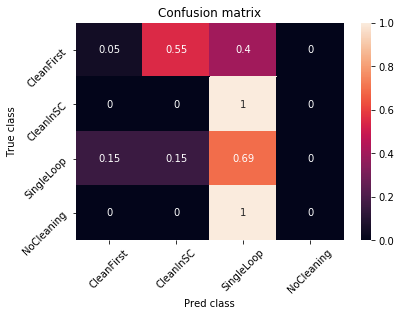

In [98]:
trainer.model.eval()
trainer.eval_on(student_dataset.loader(student_dataset.dataset)).plot_cm(normalize=False)

In [93]:
for _, row in df[df.labels == GeneralRainfallLabels.SingleLoop].iterrows():
    print(row.source)
    print('\n{}\n'.format('='*15))

fun rainfall(nums :: List<Number>) -> Number:
  #this took approximatly 25-30 minutes
  fun get-values(lst :: List<Number>) -> {sum : Number, length : Number}:
    doc: "returns the sum of the correct values in lst, and the number of correct values"
    cases(List<Numbers>) lst:
      | empty => {sum : 0, length : 0}
      | link(f,r) =>
        if f == -999:
          {sum : 0, length : 0}
        else if f < 0:
          v = get-values(r)
          {sum : v.sum, length : v.length}
        else:
          v = get-values(r)
          {sum : v.sum + f, length : v.length + 1}
        end
    end
  end
  vals = get-values(nums)
  if vals.length == 0:
    raise("error: no correct input values")
  else:
    vals.sum / vals.length
  end
  where:
  test1 = [2, 10, 0, -5, 4, -999, 3, 5, -3]
  test2 = []
  test3 = [-999, 4, 8, 0]
  test4 = [-5, 4, 8, 0]
  test5 = [-4, -7, -2, -10, -999, 5, 7, -999]
  rainfall(test1) is 4
  rainfall(test2) raises("error: no correct input values")
  rainfall(test